In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import remove_small_holes, remove_small_objects
from sklearn.cluster import KMeans

Importation de l'image et conversion vers l'espace HSV

In [2]:
image_orig = cv2.imread('/content/testtt2.jpg')
# Conversion vers l'espace HSV
image_hsv = cv2.cvtColor(image_orig, cv2.COLOR_BGR2HSV)

# Histogrammes


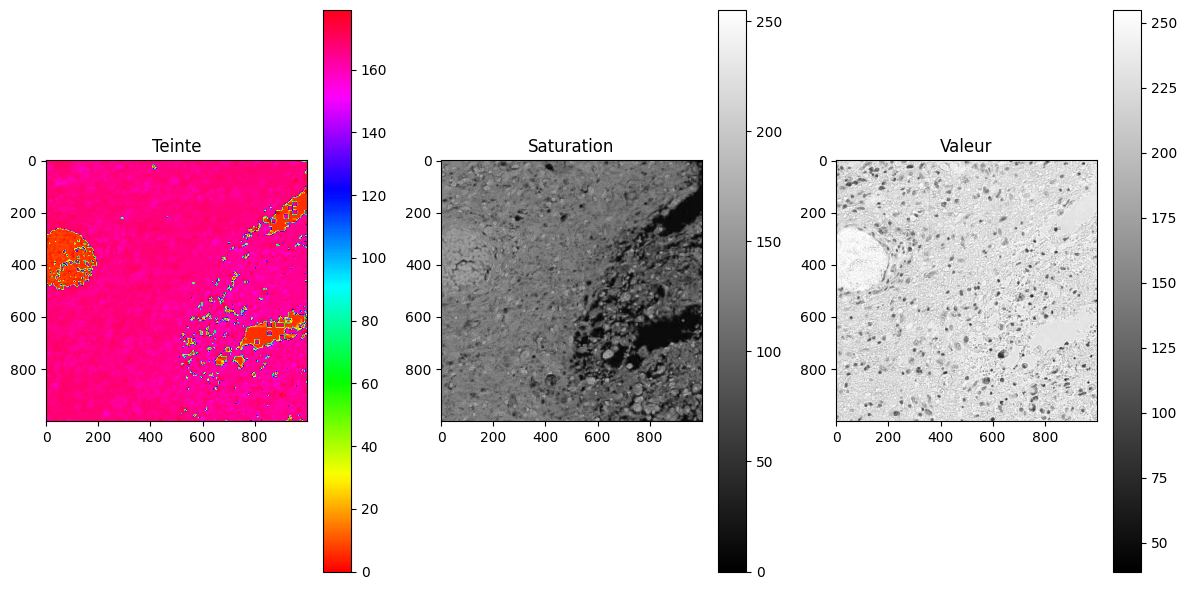

In [3]:
# Diviser l'image HSV en canaux individuels
h, s, v = cv2.split(image_hsv)

# Affichage des canaux HSV
plt.figure(figsize=(12, 6))

plt.subplot(131)
plt.title('Teinte')
plt.imshow(h, cmap='hsv')
plt.colorbar()

plt.subplot(132)
plt.title('Saturation')
plt.imshow(s, cmap='gray')
plt.colorbar()

plt.subplot(133)
plt.title('Valeur')
plt.imshow(v, cmap='gray')
plt.colorbar()

plt.tight_layout()
plt.show()

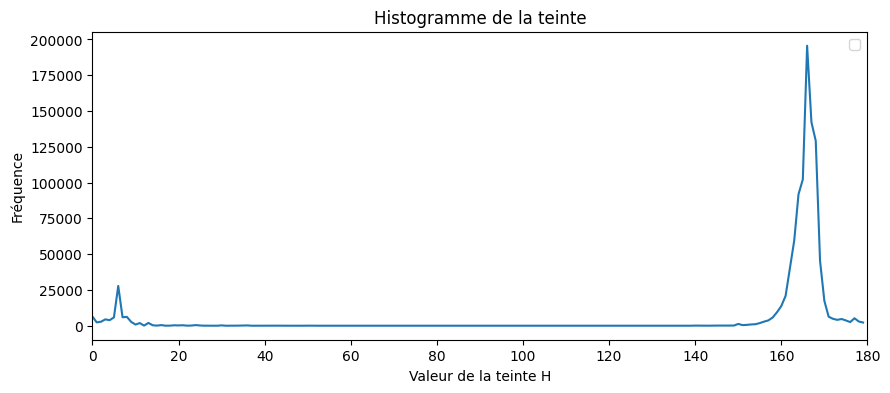

In [4]:
# Liste des images
images = [image_hsv]

plt.figure(figsize=(10, 4))

# Calcul de l'histogramme pour chaque image
for image in images:
    hist_teinte = cv2.calcHist([image], [0], None, [180], [0, 180])
    plt.plot(hist_teinte)

plt.xlim([0, 180])
plt.title('Histogramme de la teinte')
plt.xlabel('Valeur de la teinte H')
plt.ylabel('Fréquence')
plt.legend()
plt.show()

# **Partie segmentation (méthode 1)**

I. Seuils fixés manuellement en se basant sur les histogrammes

1.   Application d'un Filtre moyenneur 3*3.
2.   Seuillage en se basant sur les histogrammes.



In [5]:
# Application du filtre moyenneur pour lisser l'image
kernel = np.ones((3, 3), np.float32) / 9
image_hsv_smoothed = cv2.filter2D(image_hsv, -1, kernel)

In [6]:
# Fonction segmentation pour les canaux H et S
def segmentation_vaisseaux_HS(image_hsv_smoothed, lower_thresh, upper_thresh):

    Hue_Saturation = image_hsv_smoothed[:,:,:2]

    # Plage de valeurs d'intérêt
    lower_val = np.array([lower_thresh, 50])
    upper_val = np.array([upper_thresh, 255])

    # Masque pour filtrer les pixels d'intérêt
    mask = cv2.inRange(Hue_Saturation, lower_val, upper_val)

    # Retourner le masque normalisé (0 ou 1)
    return mask / 255

In [7]:
# Fonction segmentation pour les canaux S et V
def segmentation_vaisseaux_SV(image_hsv_smoothed, lower_thresh, upper_thresh):

    Saturation_Value = image_hsv_smoothed[:,:,1:3]

    # Plage de valeurs d'intérêt
    lower_val = np.array([50, lower_thresh])
    upper_val = np.array([255, upper_thresh])

    # Masque pour filtrer les pixels d'intérêt
    mask = cv2.inRange(Saturation_Value, lower_val, upper_val)

    # Retourner le masque normalisé (0 ou 1)
    return mask / 255

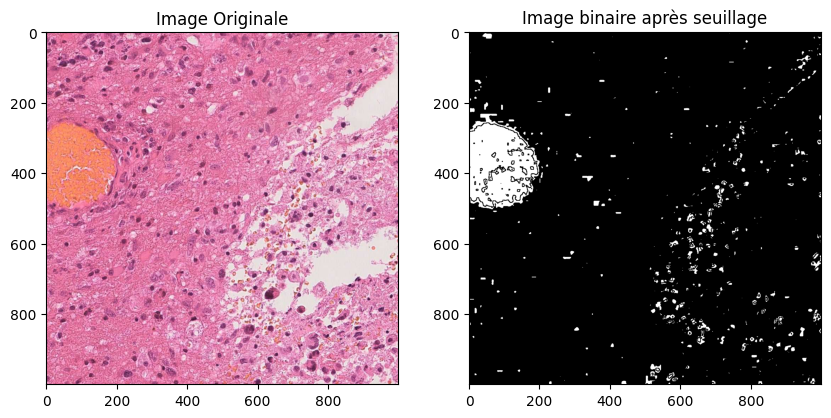

In [9]:
# Création de 3 masques
mask1 = segmentation_vaisseaux_HS(image_hsv_smoothed, 0, 20) # H entre 0 et 20 pour avoir la teinte orange et S entre 50 et 255
mask2 = segmentation_vaisseaux_HS(image_hsv_smoothed, 170, 180) # H entre 170 et 180 pour avoir la teinte rose orangé et S entre 50 et 255
mask3 = segmentation_vaisseaux_SV(image_hsv_smoothed, 50, 255) # V entre 245 et 255 et S entre 50 et 255

# Combinaison des trois masques
mask_combine = cv2.bitwise_or(mask1, mask2)
mask_combine_f = cv2.bitwise_and(mask_combine, mask3)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_orig, cv2.COLOR_BGR2RGB))
plt.title('Image Originale')

plt.subplot(1, 2, 2)
plt.imshow(mask_combine_f, cmap='gray')
plt.title('Image binaire après seuillage')

plt.show()

# **Partie segmentation (méthode2)**

II. Utilisation de k-means pour la segmentation. Deux méthodes essayées :

1. K-means appliqué sur les 3 canaux HSV.
2. K-means appliqué sur le canal de teinte uniquement.


**K-means avec 3 canaux HSV**

In [10]:
def segment_image_hsv_kmeans(image_hsv_smoothed, n_clusters):

    # Redimensionnement de l'image pour K-means
    pixel_values = image_hsv_smoothed.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    # Application de K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    labels = kmeans.fit_predict(pixel_values)
    centers = kmeans.cluster_centers_

    # Création des masques binaires pour chaque cluster
    masks = []
    fig, axes = plt.subplots(1, n_clusters + 1, figsize=(15, 10))

    axes[0].imshow(cv2.cvtColor(image_hsv_smoothed, cv2.COLOR_HSV2RGB))
    axes[0].set_title('Image Originale')
    axes[0].axis('off')

    for i in range(n_clusters):
        mask = np.where(labels.reshape(image_hsv_smoothed.shape[0], image_hsv_smoothed.shape[1]) == i, 255, 0)
        mask = mask.astype(np.uint8)
        masks.append(mask)

        # Affichage du masque pour le cluster
        axes[i + 1].imshow(mask, cmap='gray')
        axes[i + 1].set_title(f'Masque du cluster {i+1}')
        axes[i + 1].axis('off')

    plt.show()

    return masks  # Retourne la liste des masques binaires

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


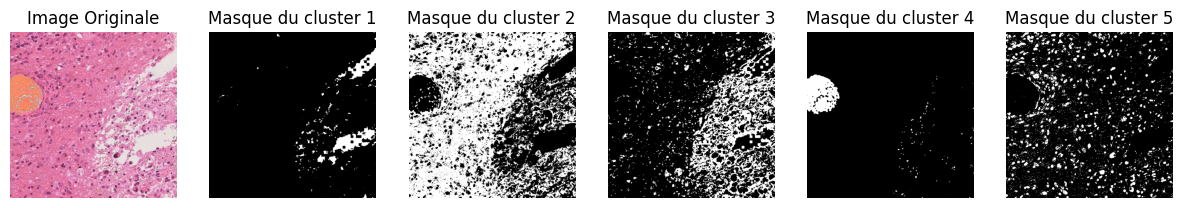

In [11]:
# Utilisation de la fonction sur une image spécifique
masks = segment_image_hsv_kmeans(image_hsv_smoothed, n_clusters=5)

**K-means avec le canal de teinte (H) uniquement**

In [12]:
def segment_image_hue_kmeans(image_hsv_smoothed, n_clusters):

    # Extraction uniquement du canal de teinte
    hue_channel = image_hsv_smoothed[:, :, 0]

    # Redimensionnement du canal de teinte pour K-means
    hue_values = hue_channel.reshape((-1, 1))
    hue_values = np.float32(hue_values)

    # Application de K-means sur le canal de teinte
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    labels = kmeans.fit_predict(hue_values)
    centers = kmeans.cluster_centers_

    # Création des masques binaires pour chaque cluster
    masks = []
    fig, axes = plt.subplots(1, n_clusters + 1, figsize=(15, 10))

    axes[0].imshow(cv2.cvtColor(image_hsv_smoothed, cv2.COLOR_HSV2RGB))
    axes[0].set_title('Image Originale')
    axes[0].axis('off')

    for i in range(n_clusters):
        mask = np.where(labels.reshape(image_hsv_smoothed.shape[0], image_hsv_smoothed.shape[1]) == i, 255, 0)
        mask = mask.astype(np.uint8)
        masks.append(mask)

        # Affichage du masque pour le cluster
        axes[i + 1].imshow(mask, cmap='gray')
        axes[i + 1].set_title(f'Masque du cluster {i+1}')
        axes[i + 1].axis('off')

    plt.show()

    return masks  # Retourne la liste des masques binaires

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


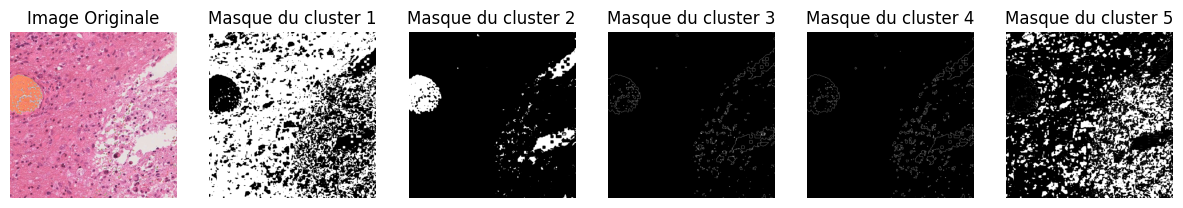

In [13]:
# Utilisation de la fonction sur une image spécifique
masks = segment_image_hue_kmeans(image_hsv_smoothed, n_clusters=5)


# **Elimination du bruit dans le masque**

Trois méthodes ont été testées :

1.   Utilisation d'un filtre médian.
2.   Détection et élimination des composantes connectées en dessous d'un certain seuil de taille.
3.   Erosion.


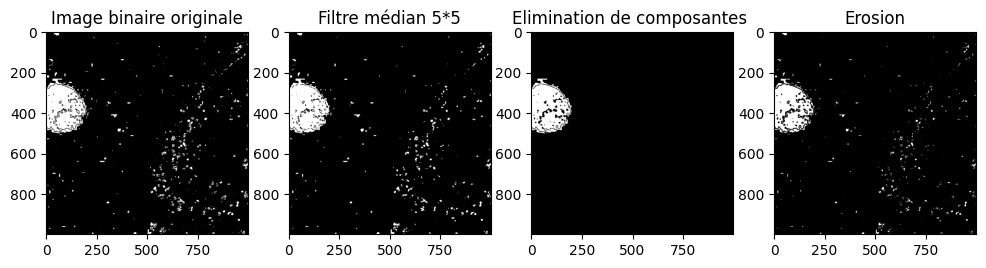

In [17]:
image_binaire = (mask_combine_f).astype('uint8')

# Filtre médian
median_filtered = cv2.medianBlur(image_binaire, 5)

# Détection et élimination des composantes connectées (connectivité de 8)
nb_components, output, stats, _ = cv2.connectedComponentsWithStats(image_binaire, connectivity=8)
sizes = stats[1:, -1]
nb_components = nb_components - 1
min_size = 400 # seuil de taille
img2 = np.zeros((output.shape), np.uint8)
for i in range(0, nb_components):
    if sizes[i] >= min_size:
        img2[output == i + 1] = 1

# Érosion
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)) # élément structurant
erosion = cv2.erode(image_binaire, kernel, iterations=1)

plt.figure(figsize=(12, 8))

plt.subplot(1, 4, 1)
plt.imshow(image_binaire, cmap='gray')
plt.title('Image binaire originale')

plt.subplot(1, 4, 2)
plt.imshow(median_filtered, cmap='gray')
plt.title('Filtre médian 5*5')

plt.subplot(1, 4, 3)
plt.imshow(img2, cmap='gray')
plt.title('Elimination de composantes ')

plt.subplot(1, 4, 4)
plt.imshow(erosion, cmap='gray')
plt.title('Erosion')

plt.show()


# **Opérations morphologiques**

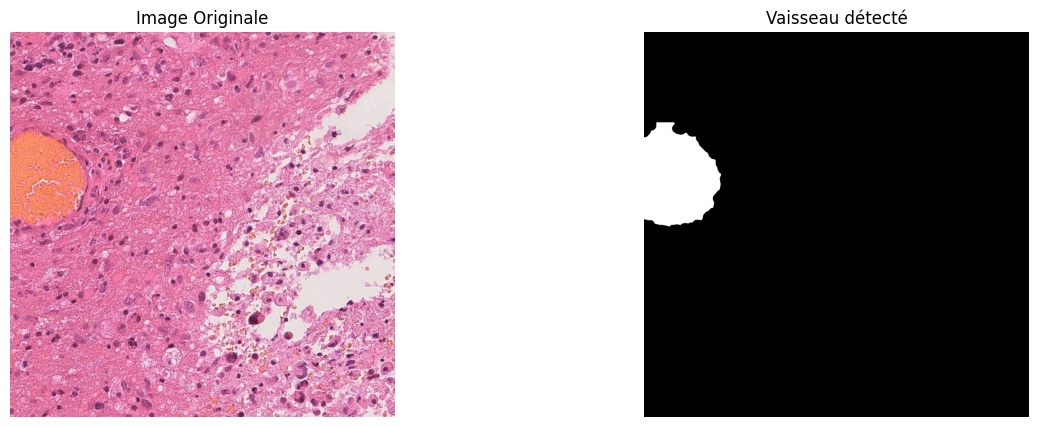

In [18]:
# Création de l'élément structurant pour la fermeture (forme elliptique)
KER = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (25, 25))

# Application de la fermeture morphologique pour combler les trous
closed_image = cv2.morphologyEx(img2, cv2.MORPH_CLOSE, KER)

# Conversion de l'image en type booléen pour le nettoyage morphologique
closed_image_bool = closed_image.astype(bool)

# Remplissage des petits trous dans les objets
filled_image = remove_small_holes(closed_image_bool, area_threshold=1000)

# Suppression des petits objets (bruit) de l'image
cleaned_image = remove_small_objects(filled_image, min_size=100)

# Conversion de l'image résultante en format binaire standard
final_image = cleaned_image.astype(np.uint8)

plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.imshow(cv2.cvtColor(image_orig, cv2.COLOR_BGR2RGB))
plt.title('Image Originale')
plt.axis('off')

plt.subplot(122)
plt.imshow(final_image, cmap='gray')
plt.title('Vaisseau détecté')
plt.axis('off')

plt.show()

# Essai interpolation avec spline cubique


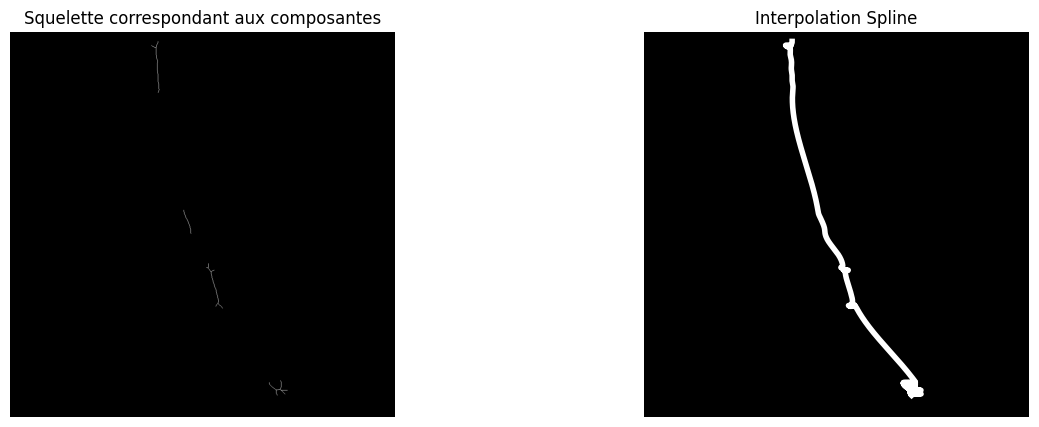

In [ ]:
from skimage import io, morphology
from scipy.interpolate import splprep, splev

image_squelette = final_image
squelette = morphology.skeletonize(image_squelette > 0)

# Extraction des coordonnées des points du squelette
y, x = np.where(squelette)

# Tri des points suivant y
sorted_indices = np.argsort(y)
x_sorted = x[sorted_indices]
y_sorted = y[sorted_indices]

# Interpolation spline
tck, u = splprep([x_sorted, y_sorted], s=100)  # s=0 signifie pas de lissage, ajustement exact
new_points = splev(np.linspace(0, 1, 1000), tck)  # génère plus de points pour la courbe


plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.imshow(squelette, cmap='gray')
plt.title('Squelette correspondant aux composantes')
plt.axis('off')

plt.subplot(122)
plt.imshow(squelette, cmap='gray')
plt.plot(new_points[0], new_points[1], "w", linewidth=4)
plt.title('Interpolation Spline')
plt.axis('off')

plt.show()

# Evaluation quantitative


In [19]:
import json
from shapely.geometry import Polygon
from PIL import Image, ImageDraw

# Extraction du masque du fichier json

def labelme_json_to_mask(json_file, image_shape):
    with open(json_file, 'r') as f:
        data = json.load(f)

    mask = np.zeros(image_shape[:2], dtype=np.uint8)

    for shape in data['shapes']:
        points = shape['points']
        polygon = Polygon(points)
        x, y = polygon.exterior.coords.xy
        coords = np.array([list(zip(x, y))], dtype=np.int32)
        cv2.fillPoly(mask, coords, 1)

    return mask

# Exemple d'utilisation
image_shape = (1000, 1000)
json_file = '/content/23_162_003DEF._patches_11_23.json'
binary_mask = labelme_json_to_mask(json_file, image_shape)

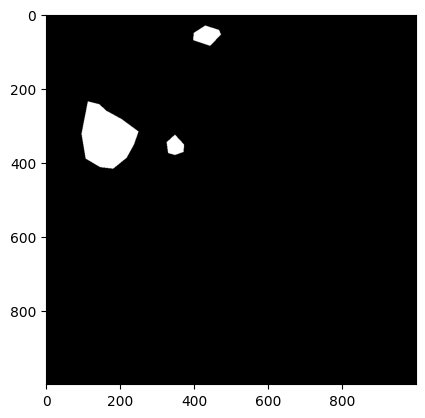

In [20]:
plt.imshow(binary_mask, cmap ="gray")

In [21]:
# Coefficient de Dice

def dice_coefficient(mask1, mask2):
    intersection = np.sum(mask1 * mask2)
    union = np.sum(mask1) + np.sum(mask2)
    return 2. * intersection / union

# Exemple d'utilisation
segmented_mask = final_image # image correspondant au masque binaire après traitement
dice_score = dice_coefficient(binary_mask, segmented_mask)
print(f'Coefficient de Dice: {dice_score}')

Coefficient de Dice: 0.31979861078737587
